In [2]:
require(data.table)
require(tidyverse)

## 1. Rationale

* due to the sparseness, the ps is binned to 100 (can change) 
* then chisq test wheter the ratio of openning is dependent on bins 

##  2. load data

In [3]:
dat.pro_ps<- fread("../dat/1901/alpha_beta.promoter.long_matrix_w_transcripts_ps.txt")
head(dat.pro_ps)
tail(dat.pro_ps)
dim(dat.pro_ps)

gene_tr.idx,cluster,cell,ps
SAMD11_7,alpha_1,Islet1-fresh_AGACACCTAGGCAGAAGTAAGGAGCAGGA,5.643735
SAMD11_7,alpha_1,Islet1-fresh_AGACACCTATGCGCAGCGTCTAATGGTTG,1.056578
SAMD11_7,alpha_2,Islet1-fresh_AGACACCTCGAGGCTGAAGGCTATGGTTG,6.254863
SAMD11_7,alpha_2,Islet1-fresh_AGACACCTCGTACTAGCTAAGCCTGTACT,6.508574
SAMD11_7,alpha_1,Islet1-fresh_AGACACCTGGACTCCTTCGACTAGGGTTG,2.120670
SAMD11_7,alpha_2,Islet1-fresh_AGACACCTGGAGCTACAAGGAGTAAGGCG,5.564368


gene_tr.idx,cluster,cell,ps
EIF1AY_133795,beta_1,Islet3-fresh_TCCGGAGAGGAGCTACTCGACTAGGTACTGAC,3.157942
EIF1AY_133795,beta_1,Islet3-fresh_TCCGGAGAGTAGAGGACTAAGCCTGGCTCTGA,4.901059
EIF1AY_133795,beta_2,Islet3-fresh_TCCGGAGATACGCTGCAAGGCTATGGTTGCGT,18.923257
EIF1AY_133795,beta_1,Islet3-fresh_TCCGGAGATAGGCATGTTCTAGCTATAGAGGC,4.655220
EIF1AY_133795,beta_2,Islet3-fresh_TCCGGAGATCGACGTCCTCTCTATCAGGACGT,14.077267
EIF1AY_133795,beta_1,Islet3-fresh_TCCGGAGATCGACGTCCTCTCTATGGTTGCGT,8.113267


[1] 19412387        4

### 2.1 bin data 

In [6]:
require(tidyverse)
ps.range <- list()
ps.range$alpha <- range((dat.pro_ps %>%filter(cluster %in% c("alpha_1","alpha_2")))$ps)
ps.range$beta <- range((dat.pro_ps %>%filter(cluster %in% c("beta_1","beta_2")))$ps)
ps.range

$alpha
[1] 0.000000 6.746176

$beta
[1]  0.0000 20.2079

In [7]:
N.bin<- 101
ps.bks <- list()
ps.bks$alpha <- seq(ps.range$alpha[1],ps.range$alpha[2],length.out = N.bin)
ps.bks$beta <- seq(ps.range$beta[1],ps.range$beta[2],length.out = N.bin)

dat.pro_ps <- rbind(
    dat.pro_ps%>% 
    filter(cluster %in% c("alpha_1","alpha_2"))%>%
    mutate(ps_bin =cut(ps,breaks = ps.bks$alpha,include.lowest = T)),
    dat.pro_ps%>% 
    filter(cluster %in% c("beta_1","beta_2"))%>%
    mutate(ps_bin =cut(ps,breaks = ps.bks$beta,include.lowest = T))
)

ps.bin.dat.sum<- dat.pro_ps%>%separate(cluster,into = c("celltype","subtype"))%>%
select(-one_of("gene_tr.idx","ps"))%>%distinct()

setDT(ps.bin.dat.sum)
ps.bin.dat.sum<-ps.bin.dat.sum[, .(.N), by = .(ps_bin,celltype)]
cat(paste(N.bin,"# bins:\n"))
cat("quantiles of alpha cell number per bin:\n")
t(quantile((ps.bin.dat.sum%>%filter(celltype=="alpha"))$N))
cat("quantiles of beta cell number per bin:\n")
t(quantile((ps.bin.dat.sum%>%filter(celltype=="beta"))$N))

101 # bins:
quantiles of alpha cell number per bin:


0%,25%,50%,75%,100%
1,21,41,71.25,257


quantiles of beta cell number per bin:


0%,25%,50%,75%,100%
2,18.75,33.5,77,655


In [8]:
ps.bin.dat.sum%>%group_by(celltype)%>%summarise(tot=sum(N))

celltype,tot
alpha,5594
beta,7170


## 3. filter on glist

In [1]:
binary.glist<- readRDS('../dat/1901/binary.glist.Rds')
all.tr <- unique(c(binary.glist$alpha1_tr,binary.glist$alpha2_tr,binary.glist$beta1_tr,binary.glist$beta2_tr))
length(all.tr)
length(c(binary.glist$alpha1_tr,binary.glist$alpha2_tr))
length(c(binary.glist$beta1_tr,binary.glist$beta2_tr))

[1] 2784

[1] 2315

[1] 904

Loading required package: venn


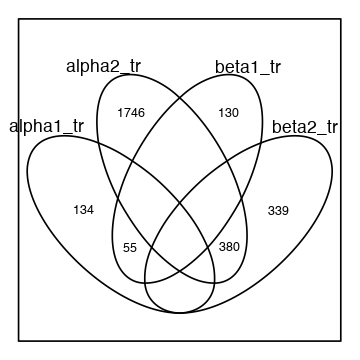

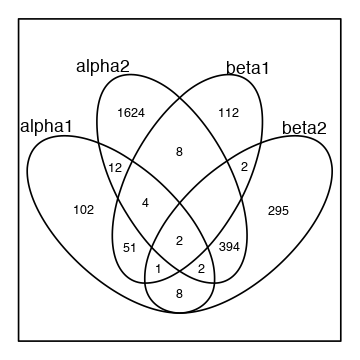

In [8]:
options(repr.plot.width=3, repr.plot.height=3)
require(venn)
binary.glist.2 <- binary.glist
binary.glist$alpha1<-NULL;binary.glist$alpha2<-NULL;binary.glist$beta1<-NULL;binary.glist$beta2<-NULL;
binary.glist.2$alpha1_tr<-NULL;binary.glist.2$alpha2_tr<-NULL;binary.glist.2$beta1_tr<-NULL;binary.glist.2$beta2_tr<-NULL;
venn(binary.glist,ellipse = T)
venn(binary.glist.2,ellipse = T)


In [9]:
#gene_tr.idx	cluster	
dim(dat.pro_ps)
dat.pro_ps.filtered <- rbind(
    dat.pro_ps%>% filter(gene_tr.idx%in% binary.glist$alpha1_tr,cluster=="alpha_1"),
    dat.pro_ps%>% filter(gene_tr.idx%in% binary.glist$alpha2_tr,cluster=="alpha_2"),
    dat.pro_ps%>% filter(gene_tr.idx%in% binary.glist$beta1_tr,cluster=="beta_1"),
    dat.pro_ps%>% filter(gene_tr.idx%in% binary.glist$beta2_tr,cluster=="beta_2")    
)
dim(dat.pro_ps.filtered)

[1] 19412387        5

[1] 778840      5

## 4. Calc percent_open & smooth

### 4.1 convert to percetage openning per bin

In [10]:
dat.pro_ps.long <- dat.pro_ps.filtered%>%
    separate(cluster,into=c("celltype","subtype"))%>%
    left_join(ps.bin.dat.sum)
dim(dat.pro_ps.long)
head(dat.pro_ps.long%>%arrange(gene_tr.idx,ps_bin))

Joining, by = c("celltype", "ps_bin")


[1] 778840      7

gene_tr.idx,celltype,subtype,cell,ps,ps_bin,N
AAGAB_42733,alpha,2,Islet1-fresh_CTATTAGGAGGCAGAAGAGCCTTAGTACT,0.4009975,"(0.337,0.405]",66
AAGAB_42733,alpha,2,Islet1-fresh_CTATTAGGAGGCAGAACCTAGAGTGTACT,0.6548890,"(0.607,0.675]",73
AAGAB_42733,alpha,2,Islet2-fresh_CTCATACAGCGTAGTAAGCCTTACTGA,2.0769056,"(2.02,2.09]",173
AAGAB_42733,alpha,2,Islet2-fresh_TGTGCAACTACGCTGCTAAGCCTGAAG,2.0265379,"(2.02,2.09]",173
AAGAB_42733,alpha,2,Islet3-fresh_ATTACTCGCTCTGGTACTAAGCCTATAGAGGC,2.0728751,"(2.02,2.09]",173
AAGAB_42733,alpha,2,Islet3-fresh_CTATTAGGTGCAGCTACCTAGAGTAGGCGAAG,3.0619376,"(3.04,3.1]",47


In [11]:
dat.pro_ps.long <- dat.pro_ps.long%>% 
    group_by(gene_tr.idx,celltype,ps_bin)%>%summarise(n= n())%>%
    left_join(ps.bin.dat.sum)%>%arrange(gene_tr.idx,ps_bin)%>%
    mutate(ps_bin.2 = as.numeric(ps_bin))%>% 
    mutate(percent_open=n/N*100)
head(dat.pro_ps.long)
dim(dat.pro_ps.long)
head(dat.pro_ps.long%>%filter(celltype=="beta"))

Joining, by = c("celltype", "ps_bin")


gene_tr.idx,celltype,ps_bin,n,N,ps_bin.2,percent_open
AAGAB_42733,alpha,"(0.337,0.405]",1,66,6,1.515152
AAGAB_42733,alpha,"(0.607,0.675]",1,73,10,1.369863
AAGAB_42733,alpha,"(2.02,2.09]",3,173,31,1.734104
AAGAB_42733,alpha,"(3.04,3.1]",1,47,46,2.127660
AAGAB_42733,alpha,"(3.44,3.51]",1,58,52,1.724138
AAGAB_42733,alpha,"(3.51,3.58]",2,63,53,3.174603


[1] 134806      7

gene_tr.idx,celltype,ps_bin,n,N,ps_bin.2,percent_open
ABCB1_117182,beta,"(6.47,6.67]",2,34,133,5.8823529
ABCB1_117182,beta,"(9.9,10.1]",1,45,150,2.2222222
ABCB1_117182,beta,"(10.5,10.7]",2,105,153,1.9047619
ABCB1_117182,beta,"(10.7,10.9]",1,123,154,0.8130081
ABCB1_117182,beta,"(10.9,11.1]",2,128,155,1.5625000
ABCB1_117182,beta,"(11.1,11.3]",1,59,156,1.6949153


In [12]:
head(dat.pro_ps.long)
dim(dat.pro_ps.long)

gene_tr.idx,celltype,ps_bin,n,N,ps_bin.2,percent_open
AAGAB_42733,alpha,"(0.337,0.405]",1,66,6,1.515152
AAGAB_42733,alpha,"(0.607,0.675]",1,73,10,1.369863
AAGAB_42733,alpha,"(2.02,2.09]",3,173,31,1.734104
AAGAB_42733,alpha,"(3.04,3.1]",1,47,46,2.127660
AAGAB_42733,alpha,"(3.44,3.51]",1,58,52,1.724138
AAGAB_42733,alpha,"(3.51,3.58]",2,63,53,3.174603


[1] 134806      7

In [15]:
dat.pro_ps.wide <- rbind(dat.pro_ps.long%>%
    filter(celltype=="alpha")%>%
    group_by(gene_tr.idx,celltype) %>%
    select(-one_of(c("ps_bin","n","N")))%>%
    spread(key = ps_bin.2,value = percent_open,fill = 0),
               dat.pro_ps.long%>%
    filter(celltype=="beta")%>%
    group_by(gene_tr.idx,celltype) %>%
    select(-one_of(c("ps_bin","n","N")))%>%
    mutate(ps_bin.2=ps_bin.2-100)%>%
    spread(key = ps_bin.2,value = percent_open,fill = 0))
head(dat.pro_ps.wide)
tail(dat.pro_ps.wide)
dim(dat.pro_ps.wide)

gene_tr.idx,celltype,1,2,3,4,5,6,7,8,⋯,91,92,93,94,95,96,97,98,99,100
AAGAB_42733,alpha,0,0,0,0,0,1.515152,0,0,⋯,20.000000,19.333333,18.691589,20.00,27.586207,38.709677,31.578947,40,33.33333,0
AAMDC_22628,alpha,0,0,0,0,0,0.000000,0,0,⋯,26.666667,33.333333,28.037383,41.25,31.034483,32.258065,36.842105,60,50.00000,50
AATF_55762,alpha,0,0,0,0,0,0.000000,0,0,⋯,7.272727,10.000000,15.887850,11.25,17.241379,9.677419,26.315789,40,16.66667,50
ABCA2_129618,alpha,0,0,0,0,0,0.000000,0,0,⋯,4.848485,8.666667,8.411215,12.50,5.172414,3.225806,5.263158,20,0.00000,0
ABCB10_11455,alpha,0,0,0,0,0,0.000000,0,0,⋯,20.606061,20.666667,31.775701,27.50,22.413793,29.032258,47.368421,30,33.33333,50
ABCB9_32864,alpha,0,0,0,0,0,0.000000,0,0,⋯,3.636364,6.000000,13.084112,3.75,12.068966,12.903226,15.789474,10,0.00000,0


gene_tr.idx,celltype,1,2,3,4,5,6,7,8,⋯,91,92,93,94,95,96,97,98,99,100
ZP1_19678,beta,0,0,0.00000,2.857143,4.651163,7.3298429,5.2147239,4.8736462,⋯,0.000000,0.0,0.000000,0.000000,0.00000,0.000,0.000000,0,0,0
ZPBP_116251,beta,0,0,0.00000,0.000000,3.488372,2.0942408,3.0674847,3.0685921,⋯,0.000000,0.0,0.000000,0.000000,0.00000,0.000,0.000000,0,0,0
ZSCAN21_117807,beta,0,0,0.00000,0.000000,0.000000,0.0000000,0.3067485,0.1805054,⋯,5.020921,7.0,6.976744,4.819277,8.62069,9.375,18.181818,10,20,0
ZSCAN31_109686,beta,0,0,0.00000,0.000000,0.000000,0.0000000,0.3067485,0.1805054,⋯,14.225941,14.0,16.279070,10.843373,20.68966,18.750,27.272727,10,40,20
ZSWIM2_79591,beta,0,50,46.66667,45.714286,23.255814,24.0837696,23.0061350,15.3429603,⋯,0.000000,0.0,0.000000,0.000000,0.00000,0.000,0.000000,0,0,0
ZSWIM5_3921,beta,0,0,0.00000,0.000000,0.000000,0.5235602,0.3067485,0.0000000,⋯,11.715481,17.5,20.155039,25.301205,13.79310,18.750,4.545455,10,20,20


[1] 3219  102

In [16]:
# wide to long again to fill 

dat.pro_ps.long <- dat.pro_ps.wide%>%gather(key = "bin",value = "percent_open",3:102)
head(dat.pro_ps.long)
tail(dat.pro_ps.long)
dim(dat.pro_ps.long)

gene_tr.idx,celltype,bin,percent_open
AAGAB_42733,alpha,1,0
AAMDC_22628,alpha,1,0
AATF_55762,alpha,1,0
ABCA2_129618,alpha,1,0
ABCB10_11455,alpha,1,0
ABCB9_32864,alpha,1,0


gene_tr.idx,celltype,bin,percent_open
ZP1_19678,beta,100,0
ZPBP_116251,beta,100,0
ZSCAN21_117807,beta,100,0
ZSCAN31_109686,beta,100,20
ZSWIM2_79591,beta,100,0
ZSWIM5_3921,beta,100,20


[1] 321900      4

### 4.2 data smooth

In [17]:
require(parallel)
dat.pro_ps.smooth <- list()
system.time(
    for(ct in c("alpha","beta")){
    dat.sub <- subset(dat.pro_ps.long,celltype==ct)
    all.tr <- unique(dat.sub$gene_tr.idx)
    dat.pro_ps.smooth[[ct]] <- mclapply(all.tr,
                           function(g){data.frame(bin=1:100,
                                                  gene_tr.idx=g,
                                                  percent_open=predict(loess(percent_open~bin, data=dat.sub%>%filter(gene_tr.idx==g))),
                                                  celltype=ct)},mc.cores=8)
})


Loading required package: parallel


   user  system elapsed 
250.006 190.730  96.960 

In [18]:
dat.pro_ps.smooth<- rbind(do.call(rbind,dat.pro_ps.smooth$alpha),
     do.call(rbind,dat.pro_ps.smooth$beta))
head(dat.pro_ps.smooth)
dim(dat.pro_ps.smooth)

bin,gene_tr.idx,percent_open,celltype
1,AAGAB_42733,0.5174754,alpha
2,AAGAB_42733,0.4584599,alpha
3,AAGAB_42733,0.4025329,alpha
4,AAGAB_42733,0.3496216,alpha
5,AAGAB_42733,0.2996535,alpha
6,AAGAB_42733,0.2525558,alpha


[1] 321900      4

In [19]:
fwrite(dat.pro_ps.smooth,file = "../dat/1901/alpha_beta.promoter.long_100bin_transcripts_ps_smoothed.txt")
fwrite(dat.pro_ps.long,file = "../dat/1901/alpha_beta.promoter.long_100bin_transcripts_ps_raw.txt")

In [1]:
?chisq.test